In [1]:
import numpy as np
import pandas as pd
import re as re
import pickle

from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as st
import scipy.special as spec
import math

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,StratifiedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from math import log

from boostaroota import BoostARoota
from xgboost import XGBClassifier, plot_importance

##########

import warnings
warnings.filterwarnings("ignore")

import nbimporter
#from libraries_setup import AllLibraries
from setup_code import *

#AllLibraries()

Importing Jupyter notebook from setup_code.ipynb


In [2]:
data = pd.read_csv('nba_shots.csv')
#data.set_index('GAME_ID1', inplace=True)

In [3]:
############################## Creating Variables ##############################

date_game = pd.DataFrame(data['MATCHUP'].str.split('-',1).tolist(), columns = ['GAME_DATE','TEAMS'])
teams = pd.DataFrame(date_game['TEAMS'].str.split(' @ | vs. ',1).tolist(), columns = ['TEAM1','TEAM2'])
minutes_split = pd.DataFrame(data['GAME_CLOCK'].str.split(':',1).tolist(), columns = ['min', 'sec'])

#GAME_DATE
data['GAME_DATE'] = pd.to_datetime(date_game['GAME_DATE'])

#HOME_TEAM
data.loc[data['LOCATION'] == 'H', 'HOME_TEAM'] = teams['TEAM1']
data.loc[data['LOCATION'] == 'A', 'HOME_TEAM'] = teams['TEAM2']

#AWAY_TEAM
data.loc[data['LOCATION'] == 'H', 'AWAY_TEAM'] = teams['TEAM2']
data.loc[data['LOCATION'] == 'A', 'AWAY_TEAM'] = teams['TEAM1']

#PLAYER_TEAM
data.loc[data['LOCATION'] == 'H', 'PLAYER_TEAM'] = data['HOME_TEAM']
data.loc[data['LOCATION'] == 'A', 'PLAYER_TEAM'] = data['AWAY_TEAM']

#GAME_CLOCK_SEC
data['GAME_CLOCK_SEC'] = pd.to_numeric(minutes_split['min'])*60 + pd.to_numeric(minutes_split['sec'])

#W
data.loc[data['W']=='W','WIN_IND'] = 1
data.loc[data['W']=='L','WIN_IND'] = 0

#THREE_POINTS_SHOT
data.loc[data['PTS_TYPE']== 3,'THREE_POINTS_SHOT'] = 1
data.loc[data['PTS_TYPE']== 2,'THREE_POINTS_SHOT'] = 0

#PLAYER_HOME
data.loc[data['LOCATION'] == 'H', 'PLAYER_HOME'] = 1
data.loc[data['LOCATION'] == 'A', 'PLAYER_HOME'] = 0

#Weekday and Month
data['GAME_WEEKDAY'] = data['GAME_DATE'].dt.weekday
data['GAME_MONTH'] = data['GAME_DATE'].dt.month

In [4]:
############################## Imputing Variables ##############################

#data.isna().sum()
data['SHOT_CLOCK'] = data['SHOT_CLOCK'].fillna(data['GAME_CLOCK_SEC'])

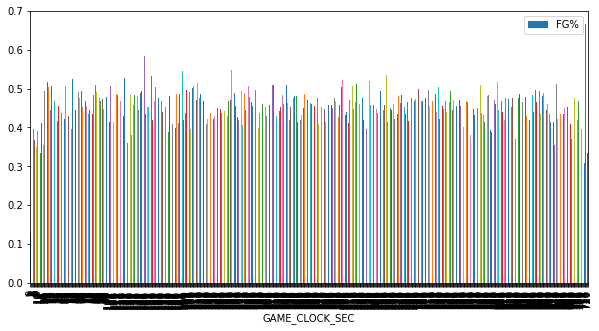

In [29]:
############################## Variables Exploration (Against Response)##############################
variable = 'GAME_CLOCK_SEC'
plot_against_response = data[[variable, 'FGM']].groupby([variable],
                                     as_index=False).mean().sort_values(by = variable, ascending = True)

plot_against_response.rename(index=str, columns={'FGM': 'FG%'}, inplace = True)
plot = plot_against_response.plot(x=variable, y = 'FG%', kind='bar', figsize = (10,5))

In [6]:
ids = ['player_id', 'CLOSEST_DEFENDER_PLAYER_ID']

for ID in ids:
    # Per Player, per Game: count how many 2pts/3pts shots they shoot/made
    three_points_metrics = data.loc[data['THREE_POINTS_SHOT']==1,:].groupby([ID, 'GAME_ID1', 'GAME_DATE', 'WIN_IND','FINAL_MARGIN']).FGM.agg(['sum', 'count']).reset_index()
    three_points_metrics.rename(index=str, columns={'sum': 'SuccessfulShots3pts', 'count': 'Shots3pts'}, inplace = True)

    two_points_metrics = data.loc[data['THREE_POINTS_SHOT']==0,:].groupby([ID, 'GAME_ID1','GAME_DATE', 'WIN_IND', 'FINAL_MARGIN']).FGM.agg(['sum', 'count']).reset_index()
    two_points_metrics.rename(index=str, columns={'sum': 'SuccessfulShots2pts', 'count': 'Shots2pts'}, inplace = True)

    #merge into one table and replace NAs with 0 shots
    player_stats = three_points_metrics.merge(two_points_metrics, on = [ID, 'GAME_ID1','GAME_DATE', 'WIN_IND', 'FINAL_MARGIN'], 
                                              how = 'outer')
    player_stats.fillna(0, inplace = True)

    #sort so that you could search for past N games
    player_stats.sort_values(by = [ID, 'GAME_DATE'], inplace = True)

    #set date as index so you'd have it in your data when you calculate rolling metrics
    player_stats.set_index('GAME_DATE', inplace = True)
    player_stats.head()

    LookAtPastGames = [3,5]
    all_history = data.loc[:, [ID, 'GAME_DATE']].drop_duplicates()

    for PastGames in LookAtPastGames:

        #Find Wins and Shots for previous N games
        player_wins = player_stats.groupby(ID)['WIN_IND'].rolling(PastGames).sum().shift(1).reset_index(name = 'PastGamesPlayerWins')
        player_final_margin = player_stats.groupby(ID)['FINAL_MARGIN'].rolling(PastGames).sum().shift(1).reset_index(name = 'PastGamesFinalMargin')

        player_shots3pt = player_stats.groupby(ID)['Shots3pts'].rolling(PastGames).sum().shift(1).reset_index()
        player_shots2pt = player_stats.groupby(ID)['Shots2pts'].rolling(PastGames).sum().shift(1).reset_index()

        player_success_shots3pt = player_stats.groupby(ID)['SuccessfulShots3pts'].rolling(PastGames).sum().shift(1).reset_index()
        player_success_shots2pt = player_stats.groupby(ID)['SuccessfulShots2pts'].rolling(PastGames).sum().shift(1).reset_index()

        #Group all the data together into "player_stats_past_games"
        total_shots = player_shots3pt.merge (player_shots2pt, on = [ID, 'GAME_DATE'], how = 'outer')
        success_shots = player_success_shots3pt.merge (player_success_shots2pt, on = [ID, 'GAME_DATE'], how = 'outer')
        player_shots = total_shots.merge (success_shots, on = [ID, 'GAME_DATE'], how = 'outer')

        player_res = player_wins.merge(player_final_margin, on = [ID, 'GAME_DATE'], how = 'outer')

        player_stats_past_games = player_shots.merge(player_res, on = [ID, 'GAME_DATE'], how = 'outer')

        #Calculate ratio metrics
        player_stats_past_games['PastGamePlayerAccuracy2pts'] = player_stats_past_games['SuccessfulShots2pts']/ player_stats_past_games['Shots2pts']
        player_stats_past_games['PastGamePlayerAccuracy3pts'] = player_stats_past_games['SuccessfulShots3pts']/ player_stats_past_games['Shots3pts']

        player_stats_past_games['PastGamesPlayerWinPrcnt'] = player_stats_past_games['PastGamesPlayerWins']/10

        columns = list(player_stats_past_games)
        columns.remove(ID)
        columns.remove('GAME_DATE')
        new_columns = [element+str(PastGames)+'Games' for element in columns]

        player_stats_past_games.rename(columns = dict(zip(columns, new_columns)), inplace = True)

        all_history = all_history.merge(player_stats_past_games,on = [ID, 'GAME_DATE'], how = 'left')

    columns = list(all_history)
    columns.remove(ID)
    columns.remove('GAME_DATE')

    ############## Add Player Stats to the Master Table #############

    new_columns_player = [ID + "_" + element for element in columns]

    #do not rename "inplace" because you need the originial names in the next steps    
    data = data.merge(all_history.rename(columns = dict(zip(columns, new_columns_player))),
                      on = [ID, 'GAME_DATE'], how = 'left')

In [7]:
############################## In Game Variables ##############################
data['Last_FGM'] = data.groupby(['player_id', 'GAME_ID1'])['FGM'].shift(1)
data['ingame_FGM_before_shot'] = data.groupby(['player_id', 'GAME_ID1'])['FGM'].cumsum().shift(1)
data['ingame_TotalFG_before_shot'] = data.groupby(['player_id', 'GAME_ID1'])['SHOT_NUMBER'].shift(1) 
data['ingame_FGM_acc_before_shot'] = data['ingame_FGM_before_shot']/data['ingame_TotalFG_before_shot']

In [8]:
############################## Delete Variables ##############################

variables_to_delete = ['GAME_ID1', 'MATCHUP', 'W', 'FINAL_MARGIN','SHOT_RESULT',
                      'PTS', 'GAME_CLOCK', 'GAME_DATE', 'PLAYER_TEAM', 'THREE_POINTS_SHOT', 
                      'WIN_IND']

for variable in variables_to_delete:
    data = data.drop (variable, 1)

In [9]:
data.dtypes

LOCATION                                                        object
SHOT_NUMBER                                                      int64
PERIOD                                                           int64
SHOT_CLOCK                                                     float64
DRIBBLES                                                         int64
TOUCH_TIME                                                     float64
SHOT_DIST                                                      float64
PTS_TYPE                                                         int64
CLOSEST_DEFENDER_PLAYER_ID                                       int64
CLOSE_DEF_DIST                                                 float64
FGM                                                              int64
player_id                                                        int64
HOME_TEAM                                                       object
AWAY_TEAM                                                       object
GAME_C

In [10]:
# ############################## Changing Variables Types ##############################

variables_to_categories = ['PERIOD', 'PTS_TYPE', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_id', 'GAME_WEEKDAY', 'GAME_MONTH']

for variable in variables_to_categories:
    data.loc[:,variable] = data[variable].astype('object')

In [11]:
# ############################## Creating Dummy Variables ##############################

# data = create_dummies(data,0)

In [12]:
y = data.loc[:,'FGM']
X = data.drop('FGM', 1)

In [13]:
test_prc = 0.2
random = 1992

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = test_prc, random_state = random)

In [14]:
data_train = X_train
data_train['FGM'] = y_train

In [15]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
# import R's "base" package
base = importr('base')
# import R's "utils" package
utils = importr('utils')
vtreat = utils.install_packages('vtreat')

In [16]:
robjects.r('''
        # create a function `vtreatTrain`
        vtreatTrain <- function(train, test, catCols, numCols) {
            data <- train
            data[catCols] <- lapply(data[catCols], as.character)
            data[numCols] <- lapply(data[numCols], as.numeric)
            vars <- setdiff(colnames(data),c('FGM'))
            # apply vtreat cross validation to develop treatments
            cfe <- vtreat::mkCrossFrameCExperiment(dframe = data,  
                                                   varlist = vars,
                                                   rareCount=10,
                                                   outcomename = 'FGM', 
                                                   outcometarget = '1'
                                                   )
            # store treatment plan
            treatments <- cfe$treatments
            # store treatment summary
            treatmentSummary <- treatments$scoreFrame
            # get treated trained data set
            dTrainTreated <- cfe$crossFrame
            test[catCols] <- lapply(test[catCols], as.character)
            test[numCols] <- lapply(test[numCols], as.numeric)
            dTestTreated <- vtreat::prepare(treatments,test)
            treatedData <- list()
            treatedData$dTrainTreated <- dTrainTreated
            treatedData$dTestTreated <- dTestTreated
            return(treatedData)
        }
        ''')


R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x00000174BDEC40C8 / R:0x00000174CB389470>

In [17]:
vtreatTrain = robjects.globalenv['vtreatTrain']

In [18]:
categorical_cols = list(data_train.select_dtypes([np.object]).columns)
numerical_cols =  list(data_train.select_dtypes([np.number]).columns)
numerical_cols.remove('FGM')
treatedData = vtreatTrain(pandas2ri.py2ri(data_train), pandas2ri.py2ri(X_test), 
                          robjects.StrVector(categorical_cols), robjects.StrVector(numerical_cols))

In [19]:
dTrainTreated = pandas2ri.ri2py(treatedData.rx2("dTrainTreated"))
dTestTreated = pandas2ri.ri2py(treatedData.rx2("dTestTreated"))

In [20]:
list(dTrainTreated)

['LOCATION_lev_x.A',
 'LOCATION_lev_x.H',
 'SHOT_NUMBER_clean',
 'PERIOD_lev_x.1',
 'PERIOD_lev_x.2',
 'PERIOD_lev_x.3',
 'PERIOD_lev_x.4',
 'PERIOD_catP',
 'PERIOD_catB',
 'SHOT_CLOCK_clean',
 'DRIBBLES_clean',
 'TOUCH_TIME_clean',
 'SHOT_DIST_clean',
 'PTS_TYPE_lev_x.2',
 'PTS_TYPE_lev_x.3',
 'CLOSEST_DEFENDER_PLAYER_ID_catP',
 'CLOSEST_DEFENDER_PLAYER_ID_catB',
 'CLOSE_DEF_DIST_clean',
 'player_id_catP',
 'player_id_catB',
 'HOME_TEAM_catP',
 'HOME_TEAM_catB',
 'AWAY_TEAM_catP',
 'AWAY_TEAM_catB',
 'GAME_CLOCK_SEC_clean',
 'PLAYER_HOME_clean',
 'GAME_WEEKDAY_lev_x.0',
 'GAME_WEEKDAY_lev_x.1',
 'GAME_WEEKDAY_lev_x.2',
 'GAME_WEEKDAY_lev_x.3',
 'GAME_WEEKDAY_lev_x.4',
 'GAME_WEEKDAY_lev_x.5',
 'GAME_WEEKDAY_lev_x.6',
 'GAME_WEEKDAY_catP',
 'GAME_WEEKDAY_catB',
 'GAME_MONTH_lev_x.1',
 'GAME_MONTH_lev_x.10',
 'GAME_MONTH_lev_x.11',
 'GAME_MONTH_lev_x.12',
 'GAME_MONTH_lev_x.2',
 'GAME_MONTH_lev_x.3',
 'GAME_MONTH_catP',
 'GAME_MONTH_catB',
 'player_id_Shots3pts3Games_clean',
 'player_id

In [21]:
variables_to_delete = ['LOCATION_lev_x.A', 'PERIOD_catP', 'PERIOD_catB', 'PERIOD_lev_x.1','PTS_TYPE_lev_x.2',
                      'CLOSEST_DEFENDER_PLAYER_ID_catP', 'player_id_catP', 'HOME_TEAM_catP', 'AWAY_TEAM_catP',
                      'GAME_WEEKDAY_lev_x.0', 'GAME_WEEKDAY_catP', 'GAME_WEEKDAY_catB', 'GAME_MONTH_lev_x.1',
                      'GAME_MONTH_catP', 'GAME_MONTH_catB']

for variable in variables_to_delete:
    dTrainTreated = dTrainTreated.drop (variable, 1)
    dTestTreated = dTestTreated.drop (variable, 1)
dTrainTreated = dTrainTreated.drop('FGM', 1)
list(dTrainTreated)

['LOCATION_lev_x.H',
 'SHOT_NUMBER_clean',
 'PERIOD_lev_x.2',
 'PERIOD_lev_x.3',
 'PERIOD_lev_x.4',
 'SHOT_CLOCK_clean',
 'DRIBBLES_clean',
 'TOUCH_TIME_clean',
 'SHOT_DIST_clean',
 'PTS_TYPE_lev_x.3',
 'CLOSEST_DEFENDER_PLAYER_ID_catB',
 'CLOSE_DEF_DIST_clean',
 'player_id_catB',
 'HOME_TEAM_catB',
 'AWAY_TEAM_catB',
 'GAME_CLOCK_SEC_clean',
 'PLAYER_HOME_clean',
 'GAME_WEEKDAY_lev_x.1',
 'GAME_WEEKDAY_lev_x.2',
 'GAME_WEEKDAY_lev_x.3',
 'GAME_WEEKDAY_lev_x.4',
 'GAME_WEEKDAY_lev_x.5',
 'GAME_WEEKDAY_lev_x.6',
 'GAME_MONTH_lev_x.10',
 'GAME_MONTH_lev_x.11',
 'GAME_MONTH_lev_x.12',
 'GAME_MONTH_lev_x.2',
 'GAME_MONTH_lev_x.3',
 'player_id_Shots3pts3Games_clean',
 'player_id_Shots3pts3Games_isBAD',
 'player_id_Shots2pts3Games_clean',
 'player_id_Shots2pts3Games_isBAD',
 'player_id_SuccessfulShots3pts3Games_clean',
 'player_id_SuccessfulShots3pts3Games_isBAD',
 'player_id_SuccessfulShots2pts3Games_clean',
 'player_id_SuccessfulShots2pts3Games_isBAD',
 'player_id_PastGamesPlayerWins3Games

In [22]:
############################## Feature Selection ##############################

# BoostARoota from: https://github.com/chasedehan/BoostARoota# BoostAR 
br = BoostARoota(metric='logloss', silent=False)

br.fit(dTrainTreated,y_train)
X_train_reduced = br.transform(dTrainTreated)

print("The algorithm reduced the data from " + str(dTrainTreated.shape[1]) + " to " + 
      str(X_train_reduced.shape[1]) + " variables")

important_variables = list (X_train_reduced)
#important_variables = list (X_train)
#important_variables

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.
The algorithm reduced the data from 108 to 65 variables


In [23]:
X_train = dTrainTreated.loc[:, important_variables]
X_test = dTestTreated.loc[:, important_variables]

In [24]:
list(important_variables)

['LOCATION_lev_x.H',
 'SHOT_NUMBER_clean',
 'PERIOD_lev_x.2',
 'PERIOD_lev_x.3',
 'PERIOD_lev_x.4',
 'SHOT_CLOCK_clean',
 'DRIBBLES_clean',
 'TOUCH_TIME_clean',
 'SHOT_DIST_clean',
 'PTS_TYPE_lev_x.3',
 'CLOSEST_DEFENDER_PLAYER_ID_catB',
 'CLOSE_DEF_DIST_clean',
 'player_id_catB',
 'HOME_TEAM_catB',
 'AWAY_TEAM_catB',
 'GAME_CLOCK_SEC_clean',
 'GAME_WEEKDAY_lev_x.1',
 'GAME_WEEKDAY_lev_x.2',
 'GAME_WEEKDAY_lev_x.6',
 'GAME_MONTH_lev_x.10',
 'GAME_MONTH_lev_x.11',
 'GAME_MONTH_lev_x.12',
 'GAME_MONTH_lev_x.2',
 'GAME_MONTH_lev_x.3',
 'player_id_Shots3pts3Games_clean',
 'player_id_Shots3pts3Games_isBAD',
 'player_id_Shots2pts3Games_clean',
 'player_id_SuccessfulShots3pts3Games_clean',
 'player_id_SuccessfulShots2pts3Games_clean',
 'player_id_PastGamesPlayerWins3Games_clean',
 'player_id_PastGamesFinalMargin3Games_clean',
 'player_id_PastGamePlayerAccuracy2pts3Games_clean',
 'player_id_PastGamePlayerAccuracy3pts3Games_clean',
 'player_id_Shots3pts5Games_clean',
 'player_id_Shots2pts5Games

In [25]:
print ("Check: \n" + 
       "Training size is " + str(X_train.shape) + "\n" + 
       "Testing size is " + str(X_test.shape) + "\n"
      )

Check: 
Training size is (102455, 65)
Testing size is (25614, 65)



In [26]:
# distributions of params from: http://danielhnyk.cz/how-to-use-xgboost-in-python/

XGBmodel = XGBClassifier()

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)
XGB_search_params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}


XGBsearch = RandomizedSearchCV(XGBmodel, XGB_search_params, cv=5, scoring = 'roc_auc', n_iter=10)
XGBsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000174CAB2D160>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000174BE3E7668>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000174CA2BD898>, 'cols...D8>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000174CAB066D8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
      

In [27]:
best_classifier = XGBClassifier()
# best_classifier.fit(X_train, y_train)

XGBparams = XGBsearch.best_params_
best_classifier.set_params(**XGBparams)
best_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9605717786744534, gamma=6.80244467747622,
       learning_rate=0.3013757845392436, max_delta_step=0, max_depth=27,
       min_child_weight=66.89013260212835, missing=None, n_estimators=27,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=22.72399916236906, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9985780377846429)

In [28]:
y_pred = best_classifier.predict(X_test)
y_pred_prob = best_classifier.predict_proba(X_test)

acc = 100*accuracy_score(y_test, y_pred)
acc

62.04809869602561

In [ ]:
plot = plot_importance(best_classifier, max_num_features=15)
#features_plot = pd.Series(best_classifier.feature_importances_, index=X_test.columns).nlargest(13).plot(kind='barh')